In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

# plotting defaults
plt.rc('figure', figsize=(16, 8))
plt.rc('font', size=16)

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

## Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.

In [2]:
from env import host, user, password

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [3]:
url = get_db_url("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
# Cluster on all or a selected subset of features
grocery_dp_deli = df[["Grocery", "Detergents_Paper", "Delicassen"]]
grocery_dp_deli.head(2)

,Grocery,Detergents_Paper,Delicassen
customer_id,,,
0,7561,2674,1338
1,9568,3293,1776


In [5]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(grocery_dp_deli)

# Use the scaler
grocery_dp_deli = scaler.transform(grocery_dp_deli)
grocery_dp_deli

array([[0.08146416, 0.0654272 , 0.02784731],
       [0.10309667, 0.08058985, 0.03698373],
       [0.08278992, 0.08605232, 0.16355861],
       ...,
       [0.32594285, 0.36346267, 0.03888194],
       [0.02402535, 0.00404174, 0.04426366],
       [0.02702178, 0.01161082, 0.00102211]])

In [6]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(grocery_dp_deli)

DBSCAN(eps=0.1, min_samples=20)

In [7]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ["Grocery", "Detergents_Paper", "Delicassen"]
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(grocery_dp_deli, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Detergents_Paper,Scaled_Delicassen
0,2,3,12669,9656,7561,214,2674,1338,0.081464,0.065427,0.027847
1,2,3,7057,9810,9568,1762,3293,1776,0.103097,0.080590,0.036984
2,2,3,6353,8808,7684,2405,3516,7844,0.082790,0.086052,0.163559
3,1,3,13265,1196,4221,6404,507,1788,0.045464,0.012346,0.037234
4,2,3,22615,5410,7198,3915,1777,5185,0.077552,0.043455,0.108093


In [8]:
# Assign the cluster labels
# Recall that cluster labels don't have inherent meaning
# DBSCAN makes a cluster called -1 that contains the "noise" or outliers
df['labels'] = dbsc.labels_
df.labels.value_counts()

 0    417
-1     23
Name: labels, dtype: int64

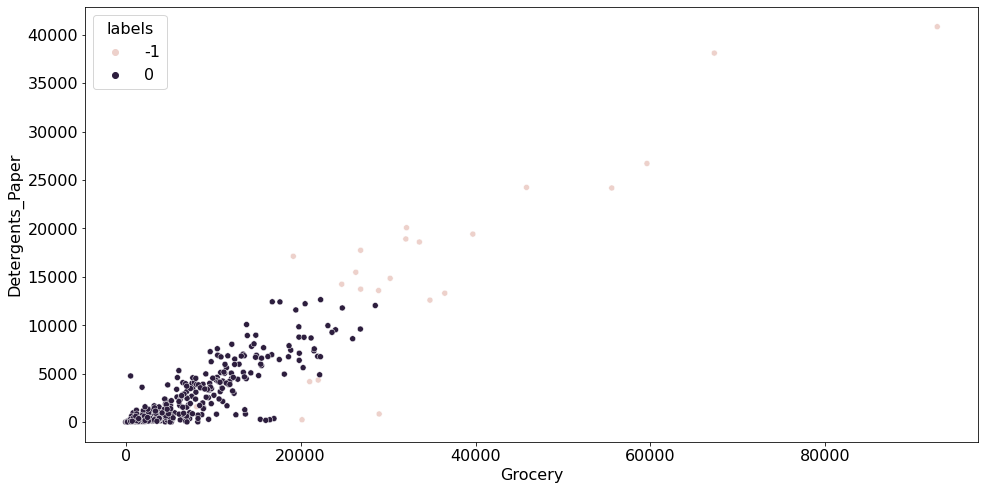

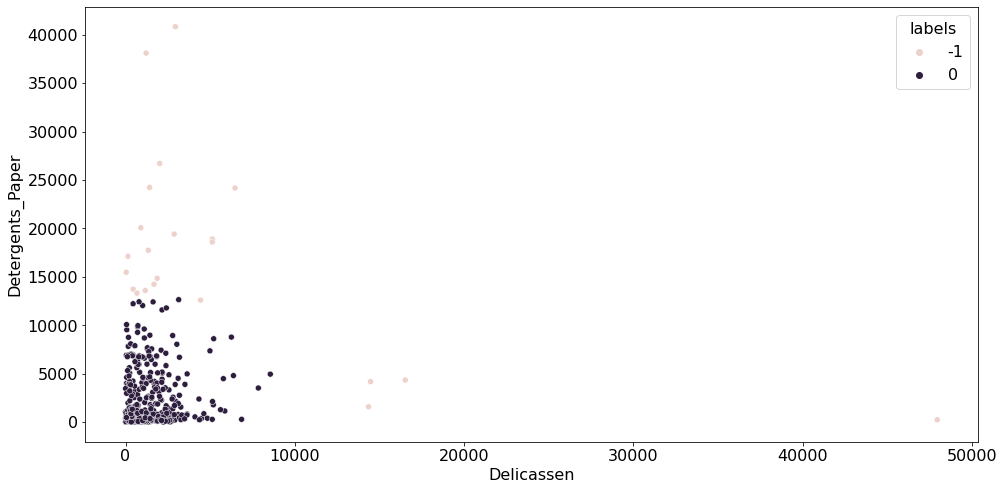

In [9]:
sns.scatterplot(df.Grocery, df.Detergents_Paper, hue=df.labels)
plt.show()

sns.scatterplot(df.Delicassen, df.Detergents_Paper, hue=df.labels)
plt.show()

Text(0.5, 0, 'Grocery')

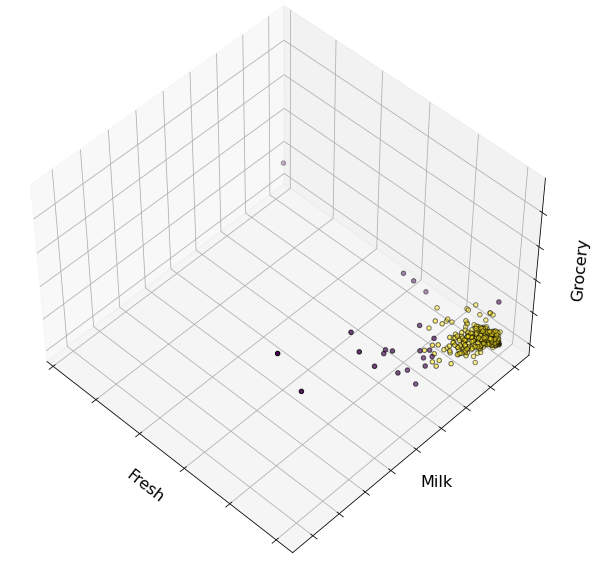

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Delicassen, df.Detergents_Paper, df.Grocery,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Milk')
ax.set_zlabel('Grocery')

## Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.

In [11]:
from wrangle import get_logs
from wrangle import prepare_log

df = get_logs()
df,ds_df, web_df= prepare_log()

In [12]:
df.head()

,date,time,path,user_id,ip,cohort_name,start_date,end_date,program_id
date,,,,,,,,,
2018-01-26,2018-01-26,09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2018-01-26,2018-01-26,09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2018-01-26,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2018-01-26,2018-01-26,09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2018-01-26,2018-01-26,09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2


In [13]:
ds_df.head()

,date,time,path,user_id,ip,cohort_name,start_date,end_date,program_id
date,,,,,,,,,
2019-08-20,2019-08-20,09:39:58,/,466,97.105.19.58,Bayes,2019-08-19,2020-01-30,3
2019-08-20,2019-08-20,09:39:59,/,467,97.105.19.58,Bayes,2019-08-19,2020-01-30,3
2019-08-20,2019-08-20,09:39:59,/,468,97.105.19.58,Bayes,2019-08-19,2020-01-30,3
2019-08-20,2019-08-20,09:40:02,/,469,97.105.19.58,Bayes,2019-08-19,2020-01-30,3
2019-08-20,2019-08-20,09:40:08,/,470,97.105.19.58,Bayes,2019-08-19,2020-01-30,3


In [14]:
web_df.head()

,date,time,path,user_id,ip,cohort_name,start_date,end_date,program_id
date,,,,,,,,,
2018-01-26,2018-01-26,09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2018-01-26,2018-01-26,09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2018-01-26,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2018-01-26,2018-01-26,09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2018-01-26,2018-01-26,09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2


In [15]:
df.program_id.value_counts()

2    713365
3    103412
1     30548
4         5
Name: program_id, dtype: int64

In [16]:
## going to look at page views for each program
# we want to look at individual users,
# and I want to know how they interact with pages in the curriculum,
# the number of unique pages and the number of total pages

page_views = df.groupby(['user_id'])['path'].agg(['count', 'nunique'])

ds_pv = ds_df.groupby(['user_id'])['path'].agg(['count', 'nunique'])

wd_pv = web_df.groupby(['user_id'])['path'].agg(['count', 'nunique'])

In [17]:
page_views.head().sort_values('count',ascending=False)

,count,nunique
user_id,,
1,7404,976
5,1701,197
3,1562,169
2,1541,151
4,692,143


In [18]:
ds_pv.head().sort_values('count',ascending=False)

,count,nunique
user_id,,
268,1212,208
466,1200,211
358,1070,159
143,808,129
467,554,186


In [19]:
wd_pv.head().sort_values('count',ascending=False)

,count,nunique
user_id,,
1,7404,976
5,1701,197
3,1562,169
2,1541,151
4,692,143


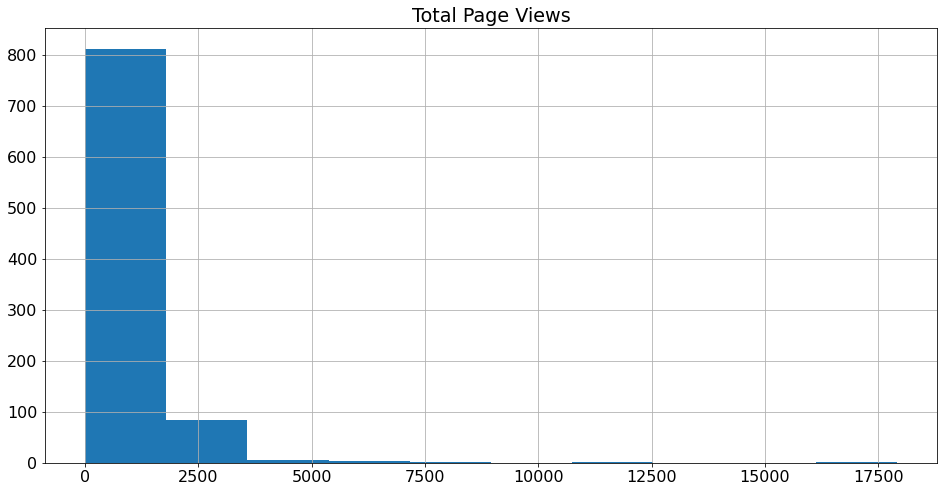

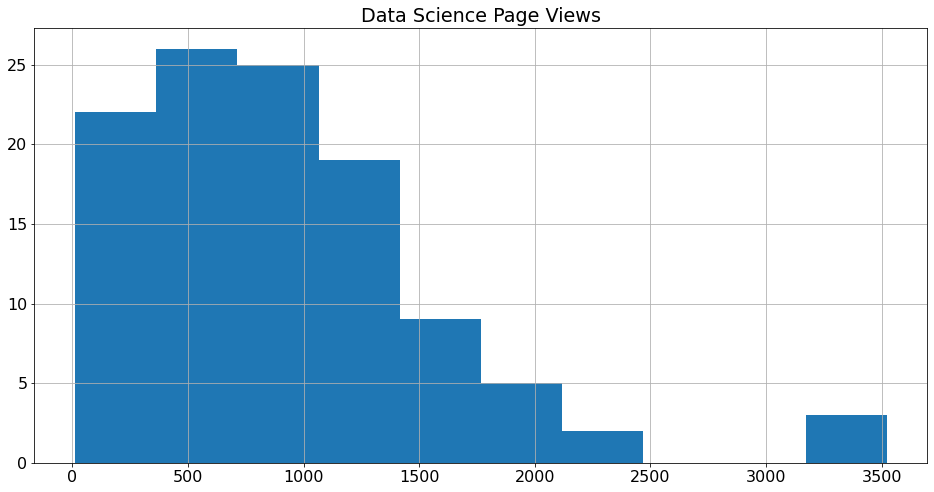

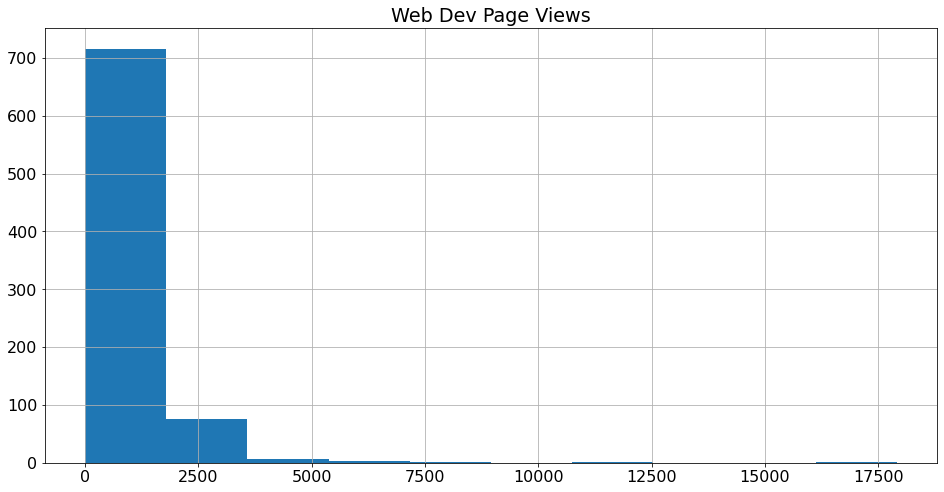

In [20]:
page_views['count'].hist()
plt.title("Total Page Views")
plt.show()
ds_pv['count'].hist()
plt.title("Data Science Page Views")
plt.show()
wd_pv['count'].hist()
plt.title("Web Dev Page Views")
plt.show()

In [22]:
# create the scaler
scaler = MinMaxScaler().fit(page_views)
# use the scaler
scaled_page_views = scaler.transform(page_views)

In [23]:
# whip up some new column names
scaled_cols = [col + '_scaled' for col in page_views.columns]

In [26]:
scaled_page_views_df = pd.DataFrame(scaled_page_views, columns=scaled_cols, index=page_views.index)

## Construct a DBSCAN object that requires a minimum of 20 data points in a neighborhood of radius 0.1 to be considered a core point.

# create the object first
dbsc = DBSCAN(min_samples=20, eps=0.1)

In [27]:
# fit the object like we normally would with sklearn
dbsc.fit(scaled_page_views_df)

DBSCAN(eps=0.1, min_samples=20)

In [28]:
dbsc.labels_.shape

(911,)

In [29]:
scaled_page_views_df.shape

(911, 2)

In [30]:
# Merge the scaled and non-scaled values into one dataframe
page_views_total = page_views.merge(
    scaled_page_views_df, on=page_views.index).drop(
    columns=['key_0'])

In [31]:
# sanity check for the shape of the df:
page_views_total.shape

(911, 4)

In [32]:
page_views_total['labels'] = dbsc.labels_
page_views_total[page_views_total.labels == -1]

,count,nunique,count_scaled,nunique_scaled,labels
0,7404,976,0.413298,1.000000,-1
10,17913,871,1.000000,0.892308,-1
51,12329,333,0.688254,0.340513,-1
56,16322,436,0.911177,0.446154,-1
226,5075,625,0.283274,0.640000,-1
292,7783,225,0.434457,0.229744,-1
382,5897,266,0.329165,0.271795,-1
448,6451,243,0.360094,0.248205,-1
533,6434,354,0.359145,0.362051,-1


In [33]:
page_views = page_views_total

# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(page_views.describe())
print("-------------")
print("Inliers")
print(page_views[page_views.labels==0].describe())
print("-------------")
print("Outliers")
print(page_views[page_views.labels==-1].describe())

Population
              count     nunique  count_scaled  nunique_scaled      labels
count    911.000000  911.000000    911.000000      911.000000  911.000000
mean     930.108672  118.299671      0.051871        0.120307   -0.009879
std     1236.014277   80.402266      0.069005        0.082464    0.098957
min        1.000000    1.000000      0.000000        0.000000   -1.000000
25%      193.000000   53.500000      0.010719        0.053846    0.000000
50%      697.000000  140.000000      0.038857        0.142564    0.000000
75%     1298.500000  165.000000      0.072437        0.168205    0.000000
max    17913.000000  976.000000      1.000000        1.000000    0.000000
-------------
Inliers
             count     nunique  count_scaled  nunique_scaled  labels
count   902.000000  902.000000    902.000000      902.000000   902.0
mean    844.480044  114.680710      0.047090        0.116596     0.0
std     771.913713   67.132615      0.043095        0.068854     0.0
min       1.000000    1.0

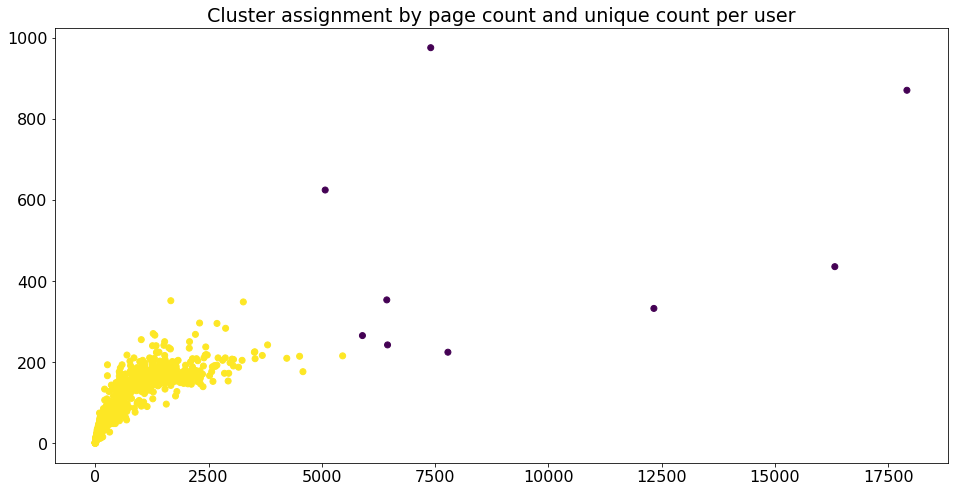

In [34]:
plt.scatter(page_views['count'],
           page_views['nunique'],
           c=page_views['labels'])
plt.title('Cluster assignment by page count and unique count per user')
plt.show()

## Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).